In [ ]:
# =============================================================================
# END-TO-END UEBA DATA PIPELINE FOR CERT r4.2 (FORENSICS READY)
# =============================================================================

import pandas as pd
import numpy as np
import os
import gc
import glob
from functools import reduce
from sklearn.preprocessing import LabelEncoder

# --- 1. CẤU HÌNH ĐƯỜNG DẪN (Dựa trên cây thư mục của bạn) ---
BASE_PATH = '/kaggle/input/cert-r4-2'
LOG_PATH = os.path.join(BASE_PATH, 'archive')             # Chứa logon, device, http...
LDAP_FOLDER = os.path.join(LOG_PATH, 'LDAP')              # Chứa các file csv theo tháng
INSIDERS_PATH = os.path.join(BASE_PATH, 'insiders.csv')   # Nằm ngoài folder archive

print("--- KIỂM TRA ĐƯỜNG DẪN ---")
print(f"Log Path tồn tại: {os.path.exists(LOG_PATH)}")
print(f"LDAP Folder tồn tại: {os.path.exists(LDAP_FOLDER)}")
print(f"Insiders File tồn tại: {os.path.exists(INSIDERS_PATH)}")
print("-" * 30)

# =============================================================================
# 2. HÀM XỬ LÝ LOG (CHUNK PROCESSING CHO FILE LỚN HTTP)
# =============================================================================
def process_log_chunked(filename, prefix, chunk_size=1000000):
    file_path = os.path.join(LOG_PATH, filename)
    if not os.path.exists(file_path):
        print(f"⚠️ Bỏ qua {filename} (Không tìm thấy)")
        return None
        
    print(f"--> Đang xử lý {filename} (Chunking)...")
    chunks_results = []
    
    try:
        # Chỉ đọc cột cần thiết để tiết kiệm RAM
        # Cột thường là: id, date, user, pc, ... -> Lấy user, date
        cols_to_use = ['user', 'date'] 
        
        for chunk in pd.read_csv(file_path, usecols=cols_to_use, chunksize=chunk_size):
            # Chuyển đổi ngày
            chunk['date'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
            chunk = chunk.dropna(subset=['date']) # Bỏ dòng lỗi
            chunk['day'] = chunk['date'].dt.date
            
            # Map: Gom nhóm ngay trong chunk
            chunk_stats = chunk.groupby(['user', 'day']).size().reset_index(name=f'{prefix}_count')
            chunks_results.append(chunk_stats)
            
            del chunk
            gc.collect()
            
        # Reduce: Gộp kết quả các chunk
        full_df = pd.concat(chunks_results)
        # Gom nhóm lần cuối (vì 1 user có thể nằm rải rác ở nhiều chunk)
        final_df = full_df.groupby(['user', 'day'])[f'{prefix}_count'].sum().reset_index()
        
        print(f"   + Xong {filename}. Kích thước: {final_df.shape}")
        return final_df

    except Exception as e:
        print(f"❌ Lỗi xử lý {filename}: {e}")
        return None

# --- CHẠY XỬ LÝ LOG ---
# File http rất lớn nên chắc chắn phải chunk, các file kia chunk cho an toàn
df_logon = process_log_chunked('logon.csv', 'logon')
df_device = process_log_chunked('device.csv', 'device')
df_http = process_log_chunked('http.csv', 'http', chunk_size=1000000) # Tăng size lên 5tr nếu RAM cho phép
df_file = process_log_chunked('file.csv', 'file')
df_email = process_log_chunked('email.csv', 'email')

# =============================================================================
# 3. MERGE LOG THÀNH MASTER TABLE
# =============================================================================
print("\n--> Đang ghép các bảng Log hành vi...")
dfs_list = [df for df in [df_logon, df_device, df_http, df_file, df_email] if df is not None]

# Merge tất cả theo User + Day
master_df = reduce(lambda left, right: pd.merge(left, right, on=['user', 'day'], how='outer'), dfs_list)
master_df = master_df.fillna(0) # Điền 0 cho hành động không xảy ra

# Dọn dẹp RAM
del df_logon, df_device, df_http, df_file, df_email, dfs_list
gc.collect()

# =============================================================================
# 4. XỬ LÝ LDAP LỊCH SỬ (HISTORICAL LDAP MERGE)
# =============================================================================
print("\n--> Đang xử lý LDAP theo từng tháng (Lịch sử chức vụ)...")
ldap_files = glob.glob(os.path.join(LDAP_FOLDER, '*.csv'))
ldap_history_list = []

# Mã hóa LabelEncoder chung cho toàn bộ lịch sử để đồng nhất
le_role = LabelEncoder()
le_dept = LabelEncoder()
le_func = LabelEncoder()
le_biz = LabelEncoder()
le_team = LabelEncoder()

# Đọc tạm tất cả để fit Encoder trước (Tránh trường hợp tháng này có Role mới mà tháng kia không có)
# Lưu ý: Nếu RAM yếu, bước này có thể bỏ qua và fit từng phần, nhưng fit all chuẩn hơn.
temp_roles = set()
temp_depts = set()
temp_funcs = set()
temp_biz = set()
temp_teams = set()

for f in ldap_files:
    try:
        cols_to_use = ['role', 'department', 'functional_unit', 'business_unit', 'team']
        temp = pd.read_csv(f, usecols=cols_to_use)
        
        # Thêm vào tập từ vựng (dùng set để không trùng lặp)
        temp_roles.update(temp['role'].astype(str).unique())
        temp_depts.update(temp['department'].astype(str).unique())
        temp_funcs.update(temp['functional_unit'].astype(str).unique())
        temp_biz.update(temp['business_unit'].astype(str).unique())
        temp_teams.update(temp['team'].astype(str).unique())
    except: pass

le_role.fit(list(temp_roles))
le_dept.fit(list(temp_depts))
le_func.fit(list(temp_funcs))
le_biz.fit(list(temp_biz))
le_team.fit(list(temp_teams))

# Giải phóng RAM
del temp_roles, temp_depts, temp_funcs, temp_biz, temp_teams

# Xử lý từng file LDAP
for file in ldap_files:
    filename = os.path.basename(file)
    month_str = filename.replace('.csv', '') # Lấy tên file làm tháng (VD: 2010-01)
    
    try:
        df = pd.read_csv(file)
        df = df.rename(columns={'user_id': 'user'})
        selected_cols = ['user', 'role', 'department', 'functional_unit', 'business_unit', 'team']
        df = df[selected_cols]
        
        # Mã hóa (Encoding)
        df['role_enc'] = le_role.transform(df['role'].astype(str))
        df['dept_enc'] = le_dept.transform(df['department'].astype(str))
        df['func_enc'] = le_func.transform(df['functional_unit'].astype(str))
        df['biz_enc'] = le_biz.transform(df['business_unit'].astype(str))
        df['team_enc'] = le_team.transform(df['team'].astype(str))
        
        # Thêm khóa tháng
        df['month_key'] = month_str
        
        # Chỉ lấy cột số
        final_cols = ['user', 'month_key', 'role_enc', 'dept_enc', 'func_enc', 'biz_enc', 'team_enc']
        ldap_history_list.append(df[final_cols])
    except Exception as e:
        print(f"Lỗi file LDAP {filename}: {e}")

# Gộp thành bảng lịch sử to
full_ldap = pd.concat(ldap_history_list)

# Chuẩn bị bên Master Log để merge
master_df['date_temp'] = pd.to_datetime(master_df['day'])
master_df['month_key'] = master_df['date_temp'].dt.strftime('%Y-%m') # Tạo khóa tháng khớp với LDAP

# MERGE CHÍNH XÁC: User A tháng 1 sẽ khớp với chức vụ tháng 1
print("   + Đang merge Log với LDAP...")
master_df = pd.merge(master_df, full_ldap, on=['user', 'month_key'], how='left')
master_df = master_df.fillna(-1) # Ai không có thông tin LDAP thì để -1

# Xóa cột tạm
del master_df['date_temp'], master_df['month_key'], full_ldap
gc.collect()

# =============================================================================
# 5. XỬ LÝ PSYCHOMETRIC (TÍNH CÁCH)
# =============================================================================
psy_path = os.path.join(LOG_PATH, 'psychometric.csv')
if os.path.exists(psy_path):
    print("\n--> Đang xử lý Psychometric...")
    psy_df = pd.read_csv(psy_path)
    psy_df = psy_df.rename(columns={'user_id': 'user'})
    # Merge vào Master (Thông tin tĩnh)
    master_df = pd.merge(master_df, psy_df, on='user', how='left')
    master_df = master_df.fillna(-1)

# =============================================================================
# 6. GÁN NHÃN MULTI-CLASS TỪ FILE INSIDERS (QUAN TRỌNG)
# =============================================================================
print("\n--> Đang gán nhãn Multi-class (Forensics)...")
if os.path.exists(INSIDERS_PATH):
    insiders = pd.read_csv(INSIDERS_PATH)
    
    # Lọc dataset 4.2
    insiders = insiders[insiders['dataset'].astype(str).str.contains('4.2')]
    
    # Convert ngày
    insiders['start'] = pd.to_datetime(insiders['start']).dt.date
    insiders['end'] = pd.to_datetime(insiders['end']).dt.date
    
    # Tạo nhãn mặc định 0
    master_df['label'] = 0
    
    count = 0
    for idx, row in insiders.iterrows():
        u = row['user']
        s = row['start']
        e = row['end']
        sc = int(row['scenario'])
        
        # Update Vectorized: Nhanh hơn apply rất nhiều
        mask = (master_df['user'] == u) & (master_df['day'] >= s) & (master_df['day'] <= e)
        if mask.any():
            master_df.loc[mask, 'label'] = sc
            count += 1
            
    print(f"   + Đã gán nhãn cho {count} kịch bản tấn công.")
else:
    print("❌ KHÔNG TÌM THẤY FILE INSIDERS.CSV")

# =============================================================================
# 7. KẾT QUẢ CUỐI CÙNG
# =============================================================================
master_df = master_df.sort_values(['user', 'day'])
print("\n" + "="*40)
print("XỬ LÝ HOÀN TẤT - DATASET ĐÃ SẴN SÀNG CHO DEEP LEARNING")
print("="*40)
print(f"Kích thước: {master_df.shape}")
print("Phân phối nhãn (Label Distribution):")
print(master_df['label'].value_counts())

# Lưu file nhẹ (Parquet) để lần sau dùng luôn khỏi chạy lại

print("\n5 dòng đầu tiên:")
master_df.head()

In [ ]:
master_df.to_parquet('cert_r42_processed.parquet')
print("Đã lưu file parquet")

In [ ]:
# =============================================================================
# CÔNG CỤ ĐIỀU TRA SỐ (FORENSICS DRILL-DOWN TOOL)
# =============================================================================

def investigate_activity(target_user, target_date_str, log_path):
    """
    Hàm này tìm kiếm chi tiết hành động của user trong ngày cụ thể từ log thô.
    """
    print(f"\n🔍 ĐANG ĐIỀU TRA: User {target_user} vào ngày {target_date_str}")
    print("="*60)
    
    # Chuyển đổi chuỗi ngày thành object date để so sánh
    target_date = pd.to_datetime(target_date_str).date()
    
    # 1. KIỂM TRA DEVICE (USB) - Quan trọng nhất với IP Theft
    # ---------------------------------------------------------
    device_path = os.path.join(log_path, 'device.csv')
    if os.path.exists(device_path):
        print(f"--- [DEVICE ACTIVITY] ---")
        # Đọc file device (thường nhẹ nên đọc hết được)
        df_dev = pd.read_csv(device_path)
        df_dev['date'] = pd.to_datetime(df_dev['date'])
        
        # Lọc đúng người, đúng ngày
        mask = (df_dev['user'] == target_user) & (df_dev['date'].dt.date == target_date)
        details = df_dev[mask]
        
        if not details.empty:
            for _, row in details.iterrows():
                print(f"⏰ {row['date'].time()} | Action: {row['activity']} | PC: {row['pc']}")
        else:
            print("Không có hoạt động thiết bị.")

    # 2. KIỂM TRA FILE (Copy/Move/Delete)
    # ---------------------------------------------------------
    file_path = os.path.join(log_path, 'file.csv')
    if os.path.exists(file_path):
        print(f"\n--- [FILE ACTIVITY] ---")
        df_file = pd.read_csv(file_path)
        df_file['date'] = pd.to_datetime(df_file['date'])
        
        mask = (df_file['user'] == target_user) & (df_file['date'].dt.date == target_date)
        details = df_file[mask]
        
        if not details.empty:
            # Chỉ in 10 dòng đầu nếu quá nhiều
            for _, row in details.head(10).iterrows():
                # filename và content là thông tin cực quan trọng
                print(f"⏰ {row['date'].time()} | File: {row['filename']} | Content: {row['content']}")
            if len(details) > 10: print(f"... và {len(details)-10} file khác.")
        else:
            print("Không có hoạt động file.")

    # 3. KIỂM TRA HTTP (Websites) - Web đen, Wikileaks, Job search
    # ---------------------------------------------------------
    http_path = os.path.join(log_path, 'http.csv')
    if os.path.exists(http_path):
        print(f"\n--- [HTTP ACTIVITY] ---")
        found_http = False
        
        # Vì file HTTP quá lớn, phải đọc chunk và lọc ngay
        try:
            for chunk in pd.read_csv(http_path, chunksize=2000000):
                chunk['date'] = pd.to_datetime(chunk['date'])
                mask = (chunk['user'] == target_user) & (chunk['date'].dt.date == target_date)
                results = chunk[mask]
                
                if not results.empty:
                    found_http = True
                    for _, row in results.iterrows():
                        url = row['url']
                        # Chỉ in những web đáng ngờ (để đỡ bị spam)
                        suspicious_keywords = ['wikileaks', 'dropbox', 'job', 'monster', 'career', 'keylogger']
                        if any(k in url.lower() for k in suspicious_keywords):
                             print(f"⚠️ SUSPICIOUS: ⏰ {row['date'].time()} | URL: {url}")
                        else:
                            # In đại diện vài cái bình thường
                             pass 
                    # Nếu muốn in hết thì bỏ cái if ở trên
        except Exception as e:
            print(f"Lỗi đọc file HTTP: {e}")
            
        if not found_http:
            print("Không tìm thấy truy cập web đáng ngờ (hoặc code lọc đã ẩn bớt).")

    print("\n✅ KẾT THÚC ĐIỀU TRA.")

# =============================================================================
# CÁCH SỬ DỤNG CÔNG CỤ NÀY
# =============================================================================

# Giả sử trong master_df bạn thấy dòng này bị gán nhãn 2 (Trộm cắp):
# User: CDE1920, Ngày: 2010-05-15

# Bạn gọi hàm:
investigate_activity('AAF0535', '2010-06-28', LOG_PATH)

In [ ]:
import os
import shutil

# 1. Tạo thư mục làm việc tên là 'r4.2' để thỏa mãn yêu cầu của script
work_dir = "/kaggle/working/r4.2"
os.makedirs(work_dir, exist_ok=True)

# 2. Đường dẫn gốc của dữ liệu input (Bạn cần kiểm tra lại đường dẫn này trên Kaggle của bạn)
# Thông thường nó sẽ là /kaggle/input/cert-insider-threat-r42/ hoặc tương tự
input_dir = "/kaggle/input/cert-r4-2/archive" # <--- SỬA LẠI ĐƯỜNG DẪN NÀY CHO ĐÚNG VỚI DATASET BẠN ADD

# 3. Copy hoặc Symlink dữ liệu từ Input vào thư mục làm việc
# Ta dùng symlink cho nhanh và đỡ tốn dung lượng
files_to_link = ['device.csv', 'email.csv', 'file.csv', 'http.csv', 'logon.csv', 'psychometric.csv']

print("Đang liên kết dữ liệu...")
for file in files_to_link:
    src = os.path.join(input_dir, file)
    dst = os.path.join(work_dir, file)
    if os.path.exists(src):
        if os.path.exists(dst): os.remove(dst)
        os.symlink(src, dst)
    else:
        print(f"Cảnh báo: Không tìm thấy file {file} trong input")

# 4. Xử lý riêng thư mục LDAP (vì script cần đọc file bên trong folder LDAP)
ldap_src = os.path.join(input_dir, 'LDAP')
ldap_dst = os.path.join(work_dir, 'LDAP')
if os.path.exists(ldap_src):
    if os.path.exists(ldap_dst): shutil.rmtree(ldap_dst)
    shutil.copytree(ldap_src, ldap_dst) # Copy toàn bộ thư mục LDAP
    print("Đã copy thư mục LDAP")

print("Hoàn tất chuẩn bị môi trường!")

In [ ]:
%%writefile /kaggle/working/r4.2/optimized_feature_extraction.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Optimized Feature Extraction v3.5 (Fix: Ambiguous Truth Value in Email Logic)
"""
import os, sys, time
import pandas as pd
import numpy as np
from datetime import datetime
import shutil
from joblib import Parallel, delayed
import glob

# --- CẤU HÌNH ---
DNAME = 'r4.2'
NUM_WEEK = 73 
CHUNK_SIZE = 5000000 

# MASTER SCHEMA (Để chuẩn hóa cột CSV)
ALL_COLS = [
    'id', 'date', 'user', 'pc', 'activity', 'type', 
    'to', 'cc', 'bcc', 'from', 'size', '#att', 'content', 
    'url/fname'
]

# ==========================================
# 1. HELPER & VECTORIZED LOGIC
# ==========================================
def extract_row_features_vectorized(df, users_df):
    # 1. TIME
    df['hour'] = df['dt'].dt.hour
    df['weekday'] = df['dt'].dt.weekday
    is_weekend = df['weekday'] >= 5
    is_after = (df['hour'] < 8) | (df['hour'] > 17)
    conditions = [ (is_weekend & is_after), is_weekend, is_after ]
    choices = [4, 3, 2]
    df['time'] = np.select(conditions, choices, default=1)
    
    # 2. PC CHECK
    df = df.merge(users_df[['pc']], left_on='user', right_index=True, how='left')
    df['pc_type'] = np.where(df['pc_x'] == df['pc_y'], 0, 2)
    df.drop(columns=['pc_y'], inplace=True)
    df.rename(columns={'pc_x': 'pc'}, inplace=True)

    # 3. FEATURES
    feature_cols = [f'f{i}' for i in range(20)]
    for c in feature_cols: df[c] = 0
    
    # FILE
    is_file = df['type'] == 'file'
    if is_file.any():
        fname_vals = df.loc[is_file, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_file, 'content'].astype(str).fillna('').values
        
        ftype = np.ones(len(fname_vals))
        fname_s = pd.Series(fname_vals)
        ftype[fname_s.str.contains(r'\.zip|\.rar|\.7z', regex=True)] = 2
        ftype[fname_s.str.contains(r'\.jpg|\.png|\.bmp', regex=True)] = 3
        ftype[fname_s.str.contains(r'\.doc|\.pdf', regex=True)] = 4
        ftype[fname_s.str.contains(r'\.txt|\.cfg', regex=True)] = 5
        ftype[fname_s.str.contains(r'\.exe|\.sh', regex=True)] = 6
        
        df.loc[is_file, 'f1'] = ftype
        df.loc[is_file, 'f2'] = [len(s) for s in content_vals]
        df.loc[is_file, 'f3'] = [s.count(' ')+1 for s in content_vals]
        df.loc[is_file, 'f4'] = np.where(pd.Series(fname_vals).str.startswith('C'), 1, 
                                np.where(pd.Series(fname_vals).str.startswith('R'), 2, 0))
        df.loc[is_file, 'f5'] = [s.count('\\') for s in fname_vals]

    # HTTP
    is_http = df['type'] == 'http'
    if is_http.any():
        url_vals = df.loc[is_http, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_http, 'content'].astype(str).fillna('').values
        
        htype = np.ones(len(url_vals))
        url_s = pd.Series(url_vals)
        htype[url_s.str.contains('facebook|twitter|instagram', case=False)] = 2
        htype[url_s.str.contains('dropbox|drive.google', case=False)] = 3
        htype[url_s.str.contains('job|indeed|recruit', case=False)] = 4
        htype[url_s.str.contains('wikileaks|hack', case=False)] = 5
        
        df.loc[is_http, 'f6'] = htype
        df.loc[is_http, 'f7'] = [len(s) for s in url_vals]
        df.loc[is_http, 'f8'] = [s.count('/')-2 for s in url_vals]
        df.loc[is_http, 'f9'] = [len(s) for s in content_vals]
        df.loc[is_http, 'f10'] = [s.count(' ')+1 for s in content_vals]

    # EMAIL
    is_email = df['type'] == 'email'
    if is_email.any():
        to_vals = df.loc[is_email, 'to'].astype(str).fillna('').values
        bcc_vals = df.loc[is_email, 'bcc'].astype(str).fillna('').values
        content_vals = df.loc[is_email, 'content'].astype(str).fillna('').values
        
        n_to = [s.count(';')+1 if s else 0 for s in to_vals]
        n_bcc = [s.count(';')+1 if s else 0 for s in bcc_vals]
        
        df.loc[is_email, 'f11'] = np.array(n_to) + np.array(n_bcc)
        df.loc[is_email, 'f12'] = df.loc[is_email, '#att'].fillna(0)
        
        to_s = pd.Series(to_vals)
        bcc_s = pd.Series(bcc_vals)
        
        # --- FIX LỖI TẠI ĐÂY: Thay 'or' bằng '|' và đóng ngoặc ---
        # Logic: (To nội bộ) VÀ (Bcc rỗng HOẶC Bcc nội bộ) -> Internal (0)
        # Ngược lại -> External (1)
        # Lưu ý: 'dtaa.com' là domain công ty trong dataset CERT
        
        is_internal_to = to_s.str.contains('dtaa.com', regex=False)
        is_internal_bcc = (bcc_s == '') | bcc_s.str.contains('dtaa.com', regex=False)
        
        # Nếu cả To và Bcc đều an toàn -> 0, ngược lại -> 1
        xemail = np.where(is_internal_to & is_internal_bcc, 0, 1)
        
        df.loc[is_email, 'f13'] = xemail
        df.loc[is_email, 'f17'] = df.loc[is_email, 'size'].fillna(0)
        df.loc[is_email, 'f18'] = [len(s) for s in content_vals]
        df.loc[is_email, 'f19'] = [s.count(' ')+1 for s in content_vals]

    # Act Code
    conditions = [
        df['type'] == 'logon', df['type'] == 'device', 
        df['type'] == 'http', df['type'] == 'email', df['type'] == 'file'
    ]
    choices = [1, 3, 5, 6, 7]
    df['act_code'] = np.select(conditions, choices, default=0)
    
    df.loc[(df['type']=='logon') & (df['activity']!='Logon'), 'act_code'] = 2
    df.loc[(df['type']=='device') & (df['activity']!='Connect'), 'act_code'] = 4
    
    return df

# ==========================================
# 2. STEP 1: FAST SPLIT (Standardized)
# ==========================================
def fast_split_by_week():
    # Kiểm tra số lượng file CSV
    if os.path.exists("DataByWeek") and len(glob.glob("DataByWeek/*.csv")) > 60:
        print("⚡ Step 1 (Split) đã có dữ liệu hợp lệ. Bỏ qua.")
        return

    print("🚀 Step 1: Tách dữ liệu (Vectorized + Standardized)...")
    if os.path.exists("DataByWeek"): shutil.rmtree("DataByWeek")
    os.makedirs("DataByWeek")

    START_DATE = datetime.strptime('2010-01-02', '%Y-%m-%d')
    files = ['device.csv', 'email.csv', 'file.csv', 'http.csv', 'logon.csv']
    
    for fname in files:
        if not os.path.exists(fname): continue
        print(f"  -> Xử lý {fname}...")
        act_type = fname.split('.')[0]
        
        for chunk in pd.read_csv(fname, chunksize=CHUNK_SIZE, on_bad_lines='skip', engine='python'):
            chunk['dt'] = pd.to_datetime(chunk['date'], format="%m/%d/%Y %H:%M:%S")
            chunk['week_num'] = (chunk['dt'] - START_DATE).dt.days // 7
            chunk['type'] = act_type
            
            # CHUẨN HÓA CỘT
            chunk = chunk.reindex(columns=ALL_COLS + ['week_num', 'dt'])
            
            for w, group in chunk.groupby('week_num'):
                if w < 0 or w >= NUM_WEEK: continue
                save_path = f"DataByWeek/{int(w)}.csv"
                header = not os.path.exists(save_path)
                group.drop(columns=['week_num', 'dt']).to_csv(save_path, mode='a', index=False, header=header)

# ==========================================
# 3. STEP 2: USER & LABEL
# ==========================================
def get_mal_userdata():
    possible_paths = ["/kaggle/input/cert42-answer/answers"]
    found = False
    for p in possible_paths:
        if os.path.exists(os.path.join(p, "insiders.csv")):
            if not os.path.exists("answers"):
                try: os.symlink(p, "answers")
                except: shutil.copytree(p, "answers")
            found = True
            break
            
    print("  -> Đang đọc LDAP...")
    allfiles = glob.glob('LDAP/*.csv')
    alluser = {}
    for file in sorted(allfiles):
        month = os.path.basename(file).split('.')[0]
        df_ldap = pd.read_csv(file)
        for _, row in df_ldap.iterrows():
            if row['user_id'] not in alluser:
                alluser[row['user_id']] = row.drop('user_id').tolist() + [month, np.nan]

    if os.path.isfile("psychometric.csv"):
        p_score = pd.read_csv("psychometric.csv")
        for _, row in p_score.iterrows():
            if row['user_id'] in alluser: 
                alluser[row['user_id']] += row.iloc[2:].tolist()

    cols = ['uname', 'email', 'role', 'b_unit', 'f_unit', 'dept', 'team', 'sup', 'wstart', 'wend', 'O', 'C', 'E', 'A', 'N']
    df = pd.DataFrame.from_dict(alluser, orient='index', columns=cols)
    
    if os.path.exists("DataByWeek/1.csv"):
        try:
            w1 = pd.read_csv("DataByWeek/1.csv", usecols=['user','pc'])
            user_pcs = w1.groupby('user')['pc'].apply(lambda x: list(set(x))).to_dict()
        except: user_pcs = {}
    else: user_pcs = {}
    df['pc'] = df.index.map(lambda x: user_pcs.get(x, [None])[0])

    print("  -> Nạp danh sách hành vi Insider...")
    malicious_ids_set = set()
    if os.path.exists("answers/insiders.csv"):
        insiders = pd.read_csv("answers/insiders.csv")
        insiders = insiders[insiders['dataset'].astype(str) == '4.2']
        for _, row in insiders.iterrows():
            path1 = f"answers/{row['details']}"
            path2 = f"answers/r4.2-{row['scenario']}/{os.path.basename(row['details'])}"
            final = path1 if os.path.exists(path1) else (path2 if os.path.exists(path2) else None)
            if final:
                try:
                    mal_log = pd.read_csv(final, header=None, engine='python', on_bad_lines='skip')
                    if mal_log.shape[1] > 1: malicious_ids_set.update(mal_log[1].values)
                except: pass
    
    print(f"     => {len(malicious_ids_set)} hành vi độc hại.")
    return df, malicious_ids_set

# ==========================================
# 4. STEP 3: PIPELINE (PARQUET)
# ==========================================
def process_week_vectorized(week, users_df, mal_ids_set):
    csv_path = f"DataByWeek/{week}.csv"
    if not os.path.exists(csv_path): return
    try: df = pd.read_csv(csv_path, low_memory=False)
    except: return
    if df.empty: return
    
    df['dt'] = pd.to_datetime(df['date'], format="%m/%d/%Y %H:%M:%S")
    df.sort_values('dt', inplace=True)
    
    # Extract Features
    df = extract_row_features_vectorized(df, users_df)
    
    # Label
    df['mal_act'] = df['id'].isin(mal_ids_set).astype(int)
    
    week_res = []
    
    for u, u_group in df.groupby('user'):
        if u not in users_df.index: continue
        
        u_static = users_df.loc[u, ['O','C','E','A','N','role','dept']].tolist()
        dyn_feats = [1 if (u_group['time'] >= 3).any() else 0] 
        
        act_col_map = {
            3: ['f0'], 7: ['f1','f2','f3','f4','f5'],
            6: ['f11','f12','f17','f19'], 5: ['f7','f8','f10']
        }
        
        for act_code in [1, 3, 5, 6, 7]:
            cols_to_stat = act_col_map.get(act_code, [])
            act_rows = u_group[u_group['act_code'] == act_code]
            
            for tm in ['all', 1, 2, 3]:
                if tm == 'all': curr = act_rows
                elif tm == 3: curr = act_rows[act_rows['time'] >= 3]
                else: curr = act_rows[act_rows['time'] == tm]
                
                stats = [len(curr)]
                for c in cols_to_stat:
                    if len(curr) > 0:
                        vals = pd.to_numeric(curr[c], errors='coerce').values
                        stats.extend([np.nanmean(vals), np.nanstd(vals), np.nanmin(vals), np.nanmax(vals)])
                    else: stats.extend([0,0,0,0])
                dyn_feats.extend(stats)

        is_insider = 1 if u_group['mal_act'].sum() > 0 else 0
        week_res.append([week, u] + u_static + dyn_feats + [is_insider])

    if week_res:
        out_dir = 'ExtractedData/week_parquet'
        os.makedirs(out_dir, exist_ok=True)
        res_df = pd.DataFrame(week_res)
        res_df.columns = res_df.columns.astype(str)
        res_df.to_parquet(f"{out_dir}/part_{week}.parquet", index=False)

if __name__ == "__main__":
    st = time.time()
    
    fast_split_by_week()
    print(f"✅ Step 1 Done. Time: {(time.time()-st)/60:.2f} m")
    
    users, mal_ids = get_mal_userdata()
    print(f"✅ Step 2 Done. Time: {(time.time()-st)/60:.2f} m")
    
    print("🚀 Step 3: Tính toán & Xuất Parquet...")
    Parallel(n_jobs=4)(delayed(process_week_vectorized)(i, users, mal_ids) for i in range(NUM_WEEK))
    print(f"🎉 ALL DONE. Total Time: {(time.time()-st)/60:.2f} m")

    # Kiểm tra lần cuối
    pq_files = glob.glob("ExtractedData/week_parquet/*.parquet")
    if len(pq_files) > 0:
        print(f"-> THÀNH CÔNG: Tìm thấy {len(pq_files)} file parquet.")
    else:
        print("-> CẢNH BÁO: Vẫn không thấy file parquet. Kiểm tra lại Logs.")

In [ ]:
%cd /kaggle/working/r4.2
!python graph_extraction.py 4

In [ ]:
# Xóa thư mục cũ chứa file lỗi
!rm -rf /kaggle/working/DataByWeek
!rm -rf /kaggle/working/Graph_Forensics_Data_Labeled
!rm -rf /kaggle/working/Graph_Forensics_Labeled_Final.zip
print("Đã dọn dẹp file lỗi. Bây giờ bạn hãy chạy lại script chính nhé!")

In [ ]:
# @title CERT r4.2 Feature Extraction (Corrected Paths & Chunking)
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import shutil
import tarfile
from joblib import Parallel, delayed

# ================= CONFIGURATION =================
# Cấu hình đường dẫn dựa trên hình ảnh bạn cung cấp
# 1. Đường dẫn chứa file log (device.csv, http.csv...) và thư mục LDAP
SOURCE_DIR = '/kaggle/input/cert-r4-2/archive' 

# 2. Đường dẫn chứa file nhãn (insiders.csv) và các thư mục chi tiết (r4.2-1...)
ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'

# Thư mục đầu ra
OUTPUT_DIR = '/kaggle/working'
DNAME = 'r4.2'
NUM_CORES = 4
CHUNK_SIZE = 5000000 # Tăng lên 500k để giảm số lượng file nhỏ, tối ưu I/O

# ================= HELPER FUNCTIONS =================

def get_start_date():
    # Xác định ngày bắt đầu từ file http.csv
    # fallback về 2010-01-01 nếu lỗi
    try:
        http_path = os.path.join(SOURCE_DIR, 'http.csv')
        if os.path.exists(http_path):
            # Đọc 5 dòng đầu để lấy date mẫu
            df_head = pd.read_csv(http_path, nrows=5)
            first_date = pd.to_datetime(df_head['date'].iloc[0], format='%m/%d/%Y %H:%M:%S')
            # Lùi về chủ nhật gần nhất để tính tuần cho chẵn
            start_date = first_date - timedelta(days=int(first_date.strftime("%w")))
            return start_date
    except Exception as e:
        print(f"Warning: Could not detect start date ({e}). Using default.")
    return datetime(2010, 1, 1)

# ================= STEP 1: SPLIT CSV TO WEEKLY PARQUETS =================

def process_file_chunks(act, start_date):
    """Đọc file CSV lớn theo chunk và chia nhỏ vào folder theo tuần"""
    fpath = os.path.join(SOURCE_DIR, f"{act}.csv")
    if not os.path.exists(fpath):
        print(f"File NOT found: {fpath}")
        return

    # Định nghĩa cột chuẩn cho r4.2
    cols_map = {
        'email': ['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size', 'attachments', 'content'],
        'logon': ['id', 'date', 'user', 'pc', 'activity'],
        'device': ['id', 'date', 'user', 'pc', 'activity'],
        'http': ['id', 'date', 'user', 'pc', 'url', 'content'],
        'file': ['id', 'date', 'user', 'pc', 'filename', 'content']
    }
    
    print(f"Processing {act}.csv from {fpath}...")
    
    temp_root = os.path.join(OUTPUT_DIR, "temp_split")
    chunk_idx = 0
    
    # Đọc chunk
    for chunk in pd.read_csv(fpath, chunksize=CHUNK_SIZE, on_bad_lines='skip'):
        # Rename columns nếu khớp số lượng
        if act in cols_map and len(chunk.columns) == len(cols_map[act]):
            chunk.columns = cols_map[act]
        
        # Convert date & tính tuần
        chunk['dt'] = pd.to_datetime(chunk['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
        chunk = chunk.dropna(subset=['dt']) 
        
        # Tính tuần: (Ngày hiện tại - Ngày bắt đầu) // 7
        chunk['week_idx'] = (chunk['dt'] - start_date).dt.days // 7
        chunk['type'] = act
        
        # Clean ID
        if 'id' in chunk.columns:
            chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')

        # Lưu file tạm theo tuần
        for week, group in chunk.groupby('week_idx'):
            if week < 0: continue 
            week_dir = os.path.join(temp_root, f"week_{int(week)}")
            os.makedirs(week_dir, exist_ok=True)
            
            # Lưu parquet nhỏ
            save_path = os.path.join(week_dir, f"{act}_{chunk_idx}.parquet")
            group.drop(columns=['week_idx'], inplace=True)
            group.to_parquet(save_path, index=False)
            
        chunk_idx += 1

def merge_weekly_data():
    """Gom các file parquet nhỏ thành 1 file lớn theo tuần"""
    temp_root = os.path.join(OUTPUT_DIR, "temp_split")
    target_dir = os.path.join(OUTPUT_DIR, "DataByWeek")
    os.makedirs(target_dir, exist_ok=True)
    
    if not os.path.exists(temp_root): return 0
    
    weeks = [d for d in os.listdir(temp_root) if d.startswith('week_')]
    
    def merge_worker(week_folder):
        week_id = int(week_folder.split('_')[1])
        src_path = os.path.join(temp_root, week_folder)
        files = [os.path.join(src_path, f) for f in os.listdir(src_path) if f.endswith('.parquet')]
        
        if not files: return
        
        # Merge
        df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
        df.sort_values('dt', inplace=True)
        
        # Lưu file tổng của tuần
        df.to_parquet(os.path.join(target_dir, f"{week_id}.parquet"), index=False)
    
    # Parallel Merge
    Parallel(n_jobs=NUM_CORES)(delayed(merge_worker)(w) for w in weeks)
    
    # Xóa temp để giải phóng dung lượng output Kaggle
    shutil.rmtree(temp_root)
    return len(weeks)

# ================= STEP 2: USER & LABEL PROCESSING =================

def get_user_info():
    # Đọc LDAP từ thư mục archive/LDAP
    ldap_path = os.path.join(SOURCE_DIR, 'LDAP')
    
    if not os.path.exists(ldap_path):
        print(f"Warning: LDAP folder not found at {ldap_path}")
        return pd.DataFrame()

    csvs = [os.path.join(ldap_path, f) for f in os.listdir(ldap_path) if f.endswith('.csv') and '20' in f]
    users = {}
    
    for c in sorted(csvs):
        df = pd.read_csv(c)
        for _, row in df.iterrows():
            uid = row['user_id']
            if uid not in users:
                users[uid] = row.to_dict()
            # Cập nhật thông tin mới nhất nếu có thay đổi
            users[uid].update(row.to_dict())
            
    return pd.DataFrame.from_dict(users, orient='index')

def attach_labels(users_df):
    # Đường dẫn file insiders.csv từ dataset thứ 2
    insider_csv = os.path.join(ANSWERS_DIR, "insiders.csv")
    
    if not os.path.exists(insider_csv): 
        print(f"Error: insiders.csv not found at {insider_csv}")
        return users_df

    print(f"Loading labels from {insider_csv}...")
    mal_df = pd.read_csv(insider_csv)
    
    # Lọc dataset r4.2
    mal_df = mal_df[mal_df['dataset'].astype(str) == '4.2']
    mal_df['start'] = pd.to_datetime(mal_df['start'], format='%m/%d/%Y %H:%M:%S')
    mal_df['end'] = pd.to_datetime(mal_df['end'], format='%m/%d/%Y %H:%M:%S')

    users_df['label'] = 0 # 0 = Normal
    users_df['mal_details'] = None

    for _, row in mal_df.iterrows():
        uid = row['user']
        if uid in users_df.index:
            # Gán nhãn đa lớp (Scenario ID: 1, 2, 3...)
            users_df.at[uid, 'label'] = int(row['scenario'])
            users_df.at[uid, 'mal_start'] = row['start']
            users_df.at[uid, 'mal_end'] = row['end']
            
            # Tìm file chi tiết hành vi
            # Cấu trúc folder trong hình ảnh là: answers/r4.2-1/filename.csv
            folder_name = f"r{row['dataset']}-{row['scenario']}"
            detail_file = os.path.join(ANSWERS_DIR, folder_name, row['details'])
            
            if os.path.exists(detail_file):
                with open(detail_file, 'r') as f:
                    content = f.read().strip().split('\n')
                # Lấy ID hành vi độc hại (cột thứ 2 trong file detail)
                mal_ids = [line.split(',')[1].replace('"','') for line in content]
                users_df.at[uid, 'mal_details'] = set(mal_ids)
            else:
                pass 
                # print(f"Warning: Detail file not found: {detail_file}")

    return users_df

# ================= STEP 3: FEATURE EXTRACTION (PER WEEK) =================

def extract_features_week(week_id, users_df):
    fpath = os.path.join(OUTPUT_DIR, "DataByWeek", f"{week_id}.parquet")
    if not os.path.exists(fpath): return None

    df = pd.read_parquet(fpath)
    if df.empty: return None

    results = []
    
    # Hàm hỗ trợ tính toán text
    calc_len = lambda x: len(str(x)) if pd.notnull(x) else 0
    
    # Group by User để xử lý từng người
    for uid, group in df.groupby('user'):
        if uid not in users_df.index: continue
        
        u_info = users_df.loc[uid]
        label = 0 # Mặc định lành tính (Normal)
        
        # Check Label (nếu user này nằm trong danh sách insider)
        if u_info['label'] > 0:
            # Kiểm tra thời gian hành động trong tuần này có trùng với khoảng thời gian tấn công không
            w_start, w_end = group['dt'].min(), group['dt'].max()
            if (w_start <= u_info['mal_end']) and (w_end >= u_info['mal_start']):
                label = int(u_info['label']) # Gán nhãn Scenario ID (1, 2, 3...)

        # ---------------------------------------------------------
        # TRÍCH XUẤT ĐẶC TRƯNG CƠ BẢN (AGGREGATION)
        # ---------------------------------------------------------
        
        # Tạo thêm cột phụ trợ
        group = group.copy()
        group['hour'] = group['dt'].dt.hour
        # Cuối tuần: T7(5), CN(6)
        group['is_weekend'] = group['dt'].dt.dayofweek.isin([5, 6]).astype(int)
        # Ngoài giờ hành chính (Trước 7h hoặc sau 17h)
        group['is_afterhours'] = ((group['hour'] < 7) | (group['hour'] > 17)).astype(int)
        
        # Gom nhóm theo NGÀY (Sessions based on Day)
        # Mỗi dòng dữ liệu đầu ra sẽ đại diện cho hành vi của 1 user trong 1 ngày
        group['day_date'] = group['dt'].dt.date
        
        for day, d_group in group.groupby('day_date'):
            # Đếm số lượng hành vi
            cnt_email = (d_group['type']=='email').sum()
            cnt_http = (d_group['type']=='http').sum()
            cnt_file = (d_group['type']=='file').sum()
            cnt_logon = (d_group['type']=='logon').sum()
            cnt_device = (d_group['type']=='device').sum()
            
            # Đặc trưng nội dung (ví dụ)
            avg_len = d_group['content'].apply(calc_len).mean()
            
            # Tạo vector đặc trưng
            row = {
                'uid': uid,
                'week': week_id,
                'day': day,
                'n_acts': len(d_group),
                'n_email': cnt_email,
                'n_http': cnt_http,
                'n_file': cnt_file,
                'n_logon': cnt_logon,
                'n_device': cnt_device,
                'n_afterhours': d_group['is_afterhours'].sum(),
                'n_weekend': d_group['is_weekend'].sum(),
                'avg_content_len': avg_len,
                
                # Cột LABEL quan trọng cho Multi-class Classification
                'label': label 
            }
            results.append(row)
            
    return pd.DataFrame(results)

# ================= MAIN EXECUTION =================

if __name__ == "__main__":
    st = time.time()
    
    print("=== CONFIG CHECK ===")
    print(f"Source Dir: {SOURCE_DIR} (Exists: {os.path.exists(SOURCE_DIR)})")
    print(f"Answers Dir: {ANSWERS_DIR} (Exists: {os.path.exists(ANSWERS_DIR)})")
    
    # 0. Setup
    start_date = get_start_date()
    print(f"Start Date detected: {start_date}")
    
    # 1. Chunked Reading
    print("\n=== STEP 1: Reading & Splitting Log Files ===")
    # Chỉ xử lý các file quan trọng
    acts = ['logon', 'device', 'file', 'email', 'http'] 
    for act in acts:
        process_file_chunks(act, start_date)
        
    print("\n=== STEP 1b: Merging Weekly Parquet ===")
    n_weeks = merge_weekly_data()
    print(f"-> Created data for {n_weeks} weeks.")
    
    # 2. User Info
    print("\n=== STEP 2: Building User Profile & Labels ===")
    users = get_user_info()
    users = attach_labels(users)
    print(f"-> Total users found: {len(users)}")
    print(f"-> User labels distribution (Label 0 is Normal):")
    print(users['label'].value_counts())
    
    # 3. Extraction
    print("\n=== STEP 3: Feature Extraction (Running Parallel) ===")
    weeks_available = [int(f.split('.')[0]) for f in os.listdir(os.path.join(OUTPUT_DIR, "DataByWeek")) if f.endswith('.parquet')]
    
    # Chạy song song trích xuất đặc trưng
    results = Parallel(n_jobs=NUM_CORES)(delayed(extract_features_week)(w, users) for w in weeks_available)
    
    # 4. Save
    print("\n=== STEP 4: Saving Final Dataset ===")
    final_dfs = [r for r in results if r is not None]
    if final_dfs:
        final_df = pd.concat(final_dfs, ignore_index=True)
        
        # Lưu file Parquet (nhẹ, nhanh, chuẩn cho DL)
        out_path = os.path.join(OUTPUT_DIR, "r4.2_features_multiclass.parquet")
        final_df.to_parquet(out_path, index=False)
        
        print(f"DONE! File saved to: {out_path}")
        print(f"Final Shape: {final_df.shape}")
        print(f"Final Label Distribution:\n{final_df['label'].value_counts()}")
        
        # Xóa thư mục tạm DataByWeek để tiết kiệm chỗ (nếu muốn giữ lại để debug thì comment dòng dưới)
        shutil.rmtree(os.path.join(OUTPUT_DIR, "DataByWeek"))
    else:
        print("ERROR: No data extracted!")

    print(f"Total execution time: {(time.time()-st)/60:.2f} minutes")

In [1]:
# ================= CERT r4.2 ACTION-LEVEL FINAL PIPELINE =================
# One-cell | Kaggle-ready | Deep Learning + Explainable

import os, gc, shutil, time
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# ================= CONFIG =================
SOURCE_DIR = '/kaggle/input/cert-r4-2/archive'
ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'
OUTPUT_DIR = '/kaggle/working'
CHUNK_SIZE = 2_000_000
NUM_CORES = 4

ACT_MAP = {'logon':1, 'device':2, 'file':3, 'email':4, 'http':5}
ORG_DOMAIN = 'dtaa.com'
EXEC_EXT = ('.exe','.zip','.tar')
SENSITIVE_PREFIX = 'R'
RISKY_HTTP = ['job','hack','leak','upload','drive','dropbox','keylog']

# ================= 1. USER CONTEXT =================
# ================= 1. USER CONTEXT (Đã tích hợp lưu JSON) =================
import json # Nhớ import json ở đầu script

def load_user_context():
    print("Loading LDAP + Psychometric ...")
    ldap_dir = os.path.join(SOURCE_DIR, 'LDAP')
    if not os.path.exists(ldap_dir): ldap_dir = SOURCE_DIR

    csvs = sorted([os.path.join(ldap_dir,f) for f in os.listdir(ldap_dir) if f.endswith('.csv')])
    users = {}

    for f in csvs:
        try:
            df = pd.read_csv(f)
            for _,r in df.iterrows():
                users[r['user_id']] = r.to_dict()
        except: pass

    df_users = pd.DataFrame.from_dict(users, orient='index')

    psy = os.path.join(SOURCE_DIR,'psychometric.csv')
    if os.path.exists(psy):
        df_psy = pd.read_csv(psy)
        df_users = df_users.merge(df_psy, on='user_id', how='left')
    else:
        for c in ['O','C','E','A','N']: df_users[c] = 0.5

    def enc(col):
        # Sắp xếp để đảm bảo thứ tự luôn giống nhau mỗi lần chạy
        return {v:i+1 for i,v in enumerate(sorted(col.fillna('UNK').unique()))}

    # 1. Tạo Map
    role_map = enc(df_users['role'])
    dept_map = enc(df_users['department'])
    team_map = enc(df_users['team'])

    # --- ĐOẠN MỚI THÊM VÀO: LƯU JSON NGAY TẠI ĐÂY ---
    print("Saving Mapping JSONs...")
    def save_mapping(mapping, name):
        # Đảo ngược key-value (Số -> Chữ) để sau này tra cứu
        # Chuyển key thành string để đảm bảo chuẩn JSON
        inv = {str(v): k for k,v in mapping.items()} 
        with open(f'{OUTPUT_DIR}/{name}.json','w') as f:
            json.dump(inv, f, indent=2)

    save_mapping(role_map, 'role_map')
    save_mapping(dept_map, 'dept_map')
    save_mapping(team_map, 'team_map')
    
    # Lưu luôn act_map (biến toàn cục) cho đủ bộ
    with open(f'{OUTPUT_DIR}/act_type_map.json','w') as f:
        json.dump({str(v):k for k,v in ACT_MAP.items()}, f, indent=2)
    # ------------------------------------------------

    ctx = {}
    for _,r in df_users.iterrows():
        ctx[r['user_id']] = [
            role_map.get(r['role'],0),
            dept_map.get(r['department'],0),
            team_map.get(r['team'],0),
            float(r['O']),float(r['C']),float(r['E']),float(r['A']),float(r['N'])
        ]

    print(f"-> Loaded {len(ctx)} users & Saved JSONs")
    return ctx

# ================= 2. LABELS =================
def load_labels():
    print("Loading insider labels ...")
    path = os.path.join(ANSWERS_DIR,'insiders.csv')
    if not os.path.exists(path): return {}

    df = pd.read_csv(path)
    df = df[df['dataset'].astype(str)=='4.2']
    mal = {}

    for _,r in df.iterrows():
        folder = f"r{r['dataset']}-{r['scenario']}"
        f = os.path.join(ANSWERS_DIR,folder,r['details'])
        if os.path.exists(f):
            with open(f) as fh:
                for line in fh:
                    p = line.strip().split(',')
                    if len(p)>1:
                        mal[p[1].replace('{','').replace('}','')] = int(r['scenario'])
    print(f"-> {len(mal)} malicious actions")
    return mal

# ================= 3. FEATURE PARSERS =================
def time_features(df):
    df['dt'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['dt'])
    df['ts'] = (df['dt'].astype('int64')//10**9).astype(np.int64)
    df['hour'] = df['dt'].dt.hour.astype(np.int8)
    df['dow'] = df['dt'].dt.dayofweek.astype(np.int8)
    df['is_weekend'] = df['dow'].isin([5,6]).astype(np.int8)
    df['is_night'] = ((df['hour']<7)|(df['hour']>18)).astype(np.int8)
    return df

def user_context(df, ctx):
    cols = ['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
    data = df['user'].map(lambda u: ctx.get(u,[0]*8)).tolist()
    return pd.concat([df, pd.DataFrame(data,columns=cols,index=df.index)], axis=1)

def content_len(df):
    if 'content' in df.columns:
        df['content_len'] = df['content'].fillna('').astype(str).str.len().astype(np.int32)
    else:
        df['content_len'] = 0
    return df

# ================= 4. CHUNK PROCESS =================
def process_chunk(chunk, act, ctx, mal):
    chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')
    chunk['label'] = chunk['id'].map(mal).fillna(0).astype(np.int8)
    chunk = time_features(chunk)
    chunk = user_context(chunk, ctx)
    chunk = content_len(chunk)

    chunk['act_type'] = ACT_MAP[act]

    # init
    chunk[['email_is_external','email_has_attachment','email_num_attachments',
           'file_is_executable','file_is_sensitive','http_is_risky']] = 0

    if act=='email':
        chunk['email_is_external'] = (~chunk['to'].astype(str).str.contains(ORG_DOMAIN)).astype(np.int8)
        if 'attachments' in chunk.columns:
            chunk['email_has_attachment'] = chunk['attachments'].notna().astype(np.int8)
            chunk['email_num_attachments'] = chunk['attachments'].fillna('').astype(str).str.count(';')+1
            chunk.loc[chunk['attachments'].isna(),'email_num_attachments']=0

    if act=='file':
        chunk['file_is_executable'] = chunk['filename'].astype(str).str.lower().str.endswith(EXEC_EXT).astype(np.int8)
        chunk['file_is_sensitive'] = chunk['filename'].astype(str).str.startswith(SENSITIVE_PREFIX).astype(np.int8)

    if act=='http':
        pat='|'.join(RISKY_HTTP)
        chunk['http_is_risky'] = chunk['url'].astype(str).str.contains(pat,case=False,na=False).astype(np.int8)

    final_cols = [
        'user','ts','label','act_type',
        'hour','dow','is_weekend','is_night',
        'role_id','dept_id','team_id',
        'psy_O','psy_C','psy_E','psy_A','psy_N',
        'content_len',
        'email_is_external','email_has_attachment','email_num_attachments',
        'file_is_executable','file_is_sensitive',
        'http_is_risky'
    ]
    return chunk[final_cols]

# ================= 5. FILE RUNNER =================
def process_file(act, ctx, mal):
    path = os.path.join(SOURCE_DIR,f'{act}.csv')
    if not os.path.exists(path): return
    print(f"Processing {act} ...")

    tmp = os.path.join(OUTPUT_DIR,f'tmp_{act}')
    os.makedirs(tmp,exist_ok=True)
    i=0

    for ch in pd.read_csv(path,chunksize=CHUNK_SIZE,on_bad_lines='skip'):
        df = process_chunk(ch,act,ctx,mal)
        df.to_parquet(f'{tmp}/p{i}.parquet',index=False)
        i+=1

    print(f"-> {act}: {i} chunks")

# ================= 6. MERGE =================
def merge_all():
    files=[]
    for r,_,fs in os.walk(OUTPUT_DIR):
        for f in fs:
            if f.endswith('.parquet') and 'tmp_' in r:
                files.append(os.path.join(r,f))

    print("Merging parquet files ...")
    df = pd.concat([pd.read_parquet(f) for f in files],ignore_index=True)
    df.sort_values(['user','ts'],inplace=True)

    out = os.path.join(OUTPUT_DIR,'cert_r4.2_action_level.parquet')
    df.to_parquet(out,index=False)

    print("✅ FINAL DATASET:", out)
    print("Shape:", df.shape)
    print("Labels:\n", df['label'].value_counts())

    for d in os.listdir(OUTPUT_DIR):
        if d.startswith('tmp_'): shutil.rmtree(os.path.join(OUTPUT_DIR,d))

# ================= MAIN =================
start=time.time()
ctx = load_user_context()
mal = load_labels()

acts=['logon','device','file','email','http']
Parallel(n_jobs=NUM_CORES)(delayed(process_file)(a,ctx,mal) for a in acts)

merge_all()
print(f"Total time: {(time.time()-start)/60:.2f} minutes")


Loading LDAP + Psychometric ...
Saving Mapping JSONs...
-> Loaded 1000 users & Saved JSONs
Loading insider labels ...
-> 7323 malicious actions
Processing logon ...
-> logon: 1 chunks
Processing file ...
-> file: 1 chunks
Processing email ...
-> email: 2 chunks
Merging parquet files ...
Processing device ...
-> device: 1 chunks
Processing http ...
-> http: 15 chunks
✅ FINAL DATASET: /kaggle/working/cert_r4.2_action_level.parquet
Shape: (32770222, 23)
Labels:
 label
0    32762899
2        6765
1         345
3         213
Name: count, dtype: int64
Total time: 14.08 minutes


✅ Done streaming parquet
Total rows: 32770222
Label distribution: {0: 32762899, 1: 345, 2: 6765, 3: 213}


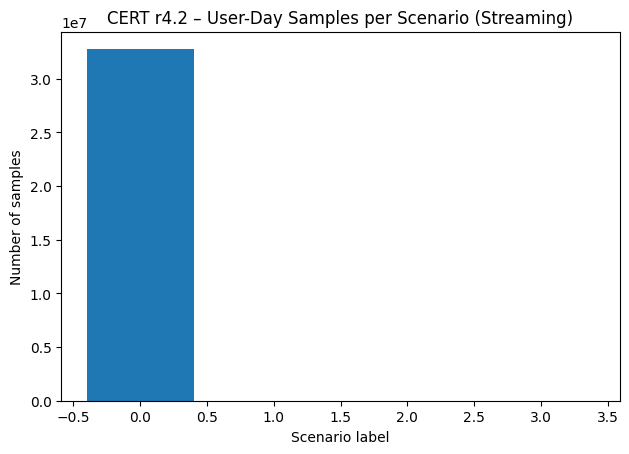

In [2]:
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
from collections import Counter

PARQUET_PATH = "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet"
BATCH_SIZE = 1_000_000

dataset = ds.dataset(PARQUET_PATH, format="parquet")

label_counter = Counter()
total_rows = 0

# ✅ API ĐÚNG CHO PYARROW HIỆN TẠI
for batch in dataset.to_batches(columns=["label"], batch_size=BATCH_SIZE):
    labels = batch.column("label").to_pylist()
    total_rows += len(labels)
    label_counter.update(labels)

print("✅ Done streaming parquet")
print("Total rows:", total_rows)
print("Label distribution:", dict(sorted(label_counter.items())))

# ===== PLOT =====
labels = sorted(label_counter.keys())
counts = [label_counter[l] for l in labels]

plt.figure()
plt.bar(labels, counts)
plt.xlabel("Scenario label")
plt.ylabel("Number of samples")
plt.title("CERT r4.2 – User-Day Samples per Scenario (Streaming)")
plt.tight_layout()
plt.show()


In [3]:
import pyarrow.dataset as ds

PARQUET_PATH = "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet"

dataset = ds.dataset(PARQUET_PATH, format="parquet")

print("Columns:")
for col in dataset.schema.names:
    print(col)


Columns:
user
ts
label
act_type
hour
dow
is_weekend
is_night
role_id
dept_id
team_id
psy_O
psy_C
psy_E
psy_A
psy_N
content_len
email_is_external
email_has_attachment
email_num_attachments
file_is_executable
file_is_sensitive
http_is_risky


In [5]:
import pyarrow.dataset as ds

dataset = ds.dataset(
    "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet",
    format="parquet"
)

batch = next(
    dataset.to_batches(
        columns=[
            # === CORE ===
            "user",
            "ts",
            "label",
            "act_type",

            # === TIME ===
            "hour",
            "dow",
            "is_weekend",
            "is_night",

            # === USER CONTEXT ===
            "role_id",
            "dept_id",
            "team_id",
            "psy_O",
            "psy_C",
            "psy_E",
            "psy_A",
            "psy_N",

            # === CONTENT ===
            "content_len",

            # === EMAIL ===
            "email_is_external",
            "email_has_attachment",
            "email_num_attachments",

            # === FILE ===
            "file_is_executable",
            "file_is_sensitive",

            # === HTTP ===
            "http_is_risky"
        ],
        batch_size=200
    )
)

batch.to_pandas()


,user,ts,label,act_type,hour,dow,is_weekend,is_night,role_id,dept_id,...,psy_E,psy_A,psy_N,content_len,email_is_external,email_has_attachment,email_num_attachments,file_is_executable,file_is_sensitive,http_is_risky
0,AAE0190,1262592540,0,1,8,0,0,0,23,5,...,14.0,50.0,29.0,0,0,0,0,0,0,0
1,AAE0190,1262592650,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,456,0,0,0,0,0,1
2,AAE0190,1262592730,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,333,0,0,0,0,0,0
3,AAE0190,1262592844,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,440,0,0,0,0,0,0
4,AAE0190,1262592960,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,385,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,AAE0190,1262685309,0,5,9,1,0,0,23,5,...,14.0,50.0,29.0,295,0,0,0,0,0,0
196,AAE0190,1262685410,0,4,9,1,0,0,23,5,...,14.0,50.0,29.0,306,0,1,1,0,0,0
197,AAE0190,1262685457,0,5,9,1,0,0,23,5,...,14.0,50.0,29.0,218,0,0,0,0,0,0
198,AAE0190,1262685644,0,5,10,1,0,0,23,5,...,14.0,50.0,29.0,438,0,0,0,0,0,0


In [8]:
import pandas as pd

df_batch = batch.to_pandas()

df_batch['datetime'] = pd.to_datetime(df_batch['ts'], unit='s')
df_batch[['ts','datetime','hour','is_night']]



,ts,datetime,hour,is_night
0,1262592540,2010-01-04 08:09:00,8,0
1,1262592650,2010-01-04 08:10:50,8,0
2,1262592730,2010-01-04 08:12:10,8,0
3,1262592844,2010-01-04 08:14:04,8,0
4,1262592960,2010-01-04 08:16:00,8,0
...,...,...,...,...
195,1262685309,2010-01-05 09:55:09,9,0
196,1262685410,2010-01-05 09:56:50,9,0
197,1262685457,2010-01-05 09:57:37,9,0
198,1262685644,2010-01-05 10:00:44,10,0


In [14]:
import pyarrow.dataset as ds
import pandas as pd

dataset = ds.dataset(
    "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet",
    format="parquet"
)

insider_users = set()

for batch in dataset.to_batches(columns=["user","label"], batch_size=1_000_000):
    df = batch.to_pandas()
    insiders = df.loc[df["label"] > 0, "user"].unique()
    insider_users.update(insiders)

len(insider_users)
malicious_count = []

for batch in dataset.to_batches(columns=["user","label"], batch_size=1_000_000):
    df = batch.to_pandas()
    tmp = df[df["label"] > 0].groupby("user").size()
    malicious_count.append(tmp)

malicious_count = pd.concat(malicious_count)
malicious_count = malicious_count.groupby(level=0).sum()

malicious_count.sort_values(ascending=False).head(10)

target_user = malicious_count.index[0]

for batch in dataset.to_batches(
    columns=["user","act_type","ts","hour","is_night","label"],
    batch_size=500_000
):
    df = batch.to_pandas()
    suspicious = df[(df["user"]==target_user) & (df["label"]>0)]
    if not suspicious.empty:
        print(suspicious.head())
        break


          user  act_type          ts  hour  is_night  label
59778  AAF0535         5  1277715068     8         0      2
59789  AAF0535         5  1277721181    10         0      2
59795  AAF0535         5  1277722850    11         0      2
59796  AAF0535         5  1277723776    11         0      2
59797  AAF0535         5  1277724205    11         0      2


Total actions of user AAF0535 : 6731


,datetime,act_name,hour,is_night,label
0,2010-01-04 08:56:00,logon,8,0,0
1,2010-01-04 09:06:37,http,9,0,0
2,2010-01-04 09:19:28,http,9,0,0
3,2010-01-04 09:24:04,http,9,0,0
4,2010-01-04 10:03:07,http,10,0,0
5,2010-01-04 10:11:49,http,10,0,0
6,2010-01-04 10:20:26,http,10,0,0
7,2010-01-04 10:36:36,http,10,0,0
8,2010-01-04 11:15:27,http,11,0,0
9,2010-01-04 11:20:14,http,11,0,0


Malicious actions: 221

Action distribution (malicious):


act_name
http      122
device     88
email      11
Name: count, dtype: int64


Hour distribution (malicious):


hour
8      2
9     24
10    29
11    21
12    35
13    31
14    37
15    22
16    19
17     1
Name: count, dtype: int64

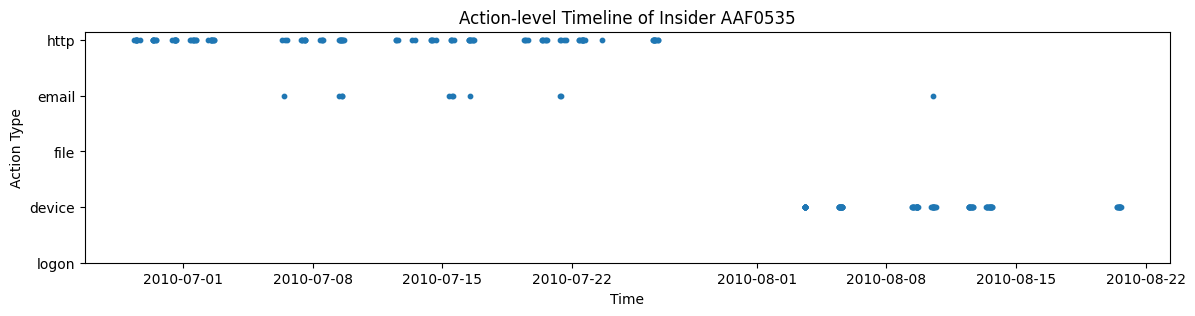

In [15]:
# ===== TRACE ACTION-LEVEL TIMELINE FOR USER AAF0535 (ONE CELL) =====

import pyarrow.dataset as ds
import pandas as pd
import json
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
PARQUET_PATH = "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet"
ACT_MAP_PATH = "/kaggle/input/cert-r42-all/act_type_map.json"
TARGET_USER = "AAF0535"
BATCH_SIZE = 500_000

# ---------- LOAD ACTION MAP ----------
with open(ACT_MAP_PATH, "r") as f:
    act_map = json.load(f)

# ---------- LOAD DATASET ----------
dataset = ds.dataset(PARQUET_PATH, format="parquet")

records = []

for batch in dataset.to_batches(
    columns=[
        "user","ts","hour","dow","is_weekend","is_night",
        "act_type","label",
        "email_is_external","email_has_attachment",
        "file_is_executable","file_is_sensitive",
        "http_is_risky"
    ],
    batch_size=BATCH_SIZE
):
    df = batch.to_pandas()
    df = df[df["user"] == TARGET_USER]
    if not df.empty:
        records.append(df)

# ---------- CONCAT & SORT ----------
timeline = pd.concat(records).sort_values("ts").reset_index(drop=True)

# ---------- TIME CONVERSION ----------
timeline["datetime"] = pd.to_datetime(timeline["ts"], unit="s")

# ---------- MAP ACTION NAME ----------
timeline["act_name"] = timeline["act_type"].astype(str).map(act_map)

print("Total actions of user", TARGET_USER, ":", len(timeline))

# ---------- SHOW FIRST ROWS ----------
display(
    timeline[
        ["datetime","act_name","hour","is_night","label"]
    ].head(20)
)

# ---------- FILTER MALICIOUS ----------
mal_timeline = timeline[timeline["label"] > 0]

print("Malicious actions:", len(mal_timeline))

# ---------- STATISTICS ----------
print("\nAction distribution (malicious):")
display(mal_timeline["act_name"].value_counts())

print("\nHour distribution (malicious):")
display(mal_timeline["hour"].value_counts().sort_index())

# ---------- VISUALIZE TIMELINE ----------
plt.figure(figsize=(14,3))
plt.scatter(
    mal_timeline["datetime"],
    mal_timeline["act_type"],
    s=10
)
plt.yticks(
    ticks=[1,2,3,4,5],
    labels=["logon","device","file","email","http"]
)
plt.title(f"Action-level Timeline of Insider {TARGET_USER}")
plt.xlabel("Time")
plt.ylabel("Action Type")
plt.show()
